In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numba import njit

# Plt rcParams font family
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'


# Whitesmoke background
#plt.rcParams['axes.facecolor'] = 'whitesmoke'

# Grid style
#plt.rcParams['grid.color'] = 'lightgrey'
#plt.rcParams['grid.linestyle'] = '--'
#plt.rcParams['grid.linewidth'] = 0.5
#plt.rcParams['axes.grid'] = True


# Assignment 4 part 2: 
# *Reaction-Diffusion equations (PDE)*

*Niels August Davidsen (phx657),*
*Handin Nov. 3rd. 2026*


_____

To solve this assignment I wrote two functions for the laplacian:
1. The first used loops for constructing the correct boundary conditions for each site at a time. This was slow initially, but as it doesn't use any complicated *numpy* functions I was able to speed it up using *numba* making it a lot faster than even the vectorized version.

2. The second used vectorized operations to help boost speed in the loop. This was way faster (about 10 times) as my first iteration using loops, but was outperformed by the *numba* optimized version.

The two algorithms can be seen below.




In [2]:
@njit
def laplacian(M, h=1.0):
    Lx, Ly = M.shape
    lap = np.zeros_like(M)
    for i in range(Lx):
        for j in range(Ly):
            up    = M[i-1, j] if i > 0 else M[i, j]
            down  = M[i+1, j] if i < Lx-1 else M[i, j]
            left  = M[i, j-1] if j > 0 else M[i, j]
            right = M[i, j+1] if j < Ly-1 else M[i, j]

            lap[i, j] = (up + down + left + right - 4 * M[i, j]) / (h * h)
    return lap


def laplacian_vec(M, h=1):
    M = np.pad(M, pad_width=1, mode='edge')
    up = M[:-2, 1:-1]
    down = M[2:, 1:-1]
    left = M[1:-1, :-2]
    right = M[1:-1, 2:]
    center = M[1:-1, 1:-1]
    lap = (up + down + left + right - 4*center) / h**2
    return lap


Otherwise I used a standard Forward Euler-method to solve the differential equations. I tried implementing the Crank-Nicholson-method, but had a lot of trouble constructing the laplacian and using the correct operations for sparse matrices. I therefore stuck to the Euler-method. 

I played around with $\Delta t$ to find something that would give me stable solutions without costing too much in terms of speed. I ended up using $\Delta t = 0.01$. All systems were simulated to $t=2000$ which means $2$ million time steps.  


I used a system size $L=40$ with the given inital conditions and used a grid-spacing $\Delta x = \Delta y = h = 1$.

First i tried simulation the system for $D_p =1, D_q=8, C=4.5$ and for $K=9$ and look at how it evolved over time. The first 3 parameters were kept constant, but K was later varied. The concentrations $p$ and $q$ are shown in the plots below, where all plots look symmetric at all time steps, which is due to the Von Neumann boundary conditions.

In [3]:
def construct_M(L, boundary=True, param=0, term=0.1):
    M = np.zeros((L, L))
    
    if boundary:
        M[10:30, 10:30] = param + term
    return M

def dp_dt(params, q, p):
    D_p, D_q, C, K = params
    lap_p = laplacian(p)
    return D_p * lap_p + p**2 * q + C - (K + 1) * p

def dq_dt(params, q, p):
    D_p, D_q, C, K = params
    lap_q = laplacian(q)
    return D_q * lap_q - p**2 * q + K*p

def run_euler(params, p_init, q_init, dt, tmax, saves):
    p = p_init.copy()
    q = q_init.copy()

    p_save = []
    q_save = []

    
    n_steps = int(tmax / dt)

    for step in range(n_steps + 1):
        if step in saves:
            p_save.append(p.copy())
            q_save.append(q.copy())

        dp = dp_dt(params, q, p)
        dq = dq_dt(params, q, p)

        p += dp * dt
        q += dq * dt

    return p, q, p_save, q_save


In [4]:
L = 40

D_p = 1
D_q = 8
C = 4.5
K = 9
dt = 0.01
tmax = 2000
 
params = [D_p, D_q, C, K]
saves = [0, 160, 320, 640, 1280, 2000]

p_init = construct_M(L, boundary=True, param=(C), term=0.1)
q_init = construct_M(L, boundary=True, param=(K/C), term=0.2)

p_final, q_final, p_save, q_save = run_euler(params, p_init, q_init, dt, tmax=tmax, saves=saves)


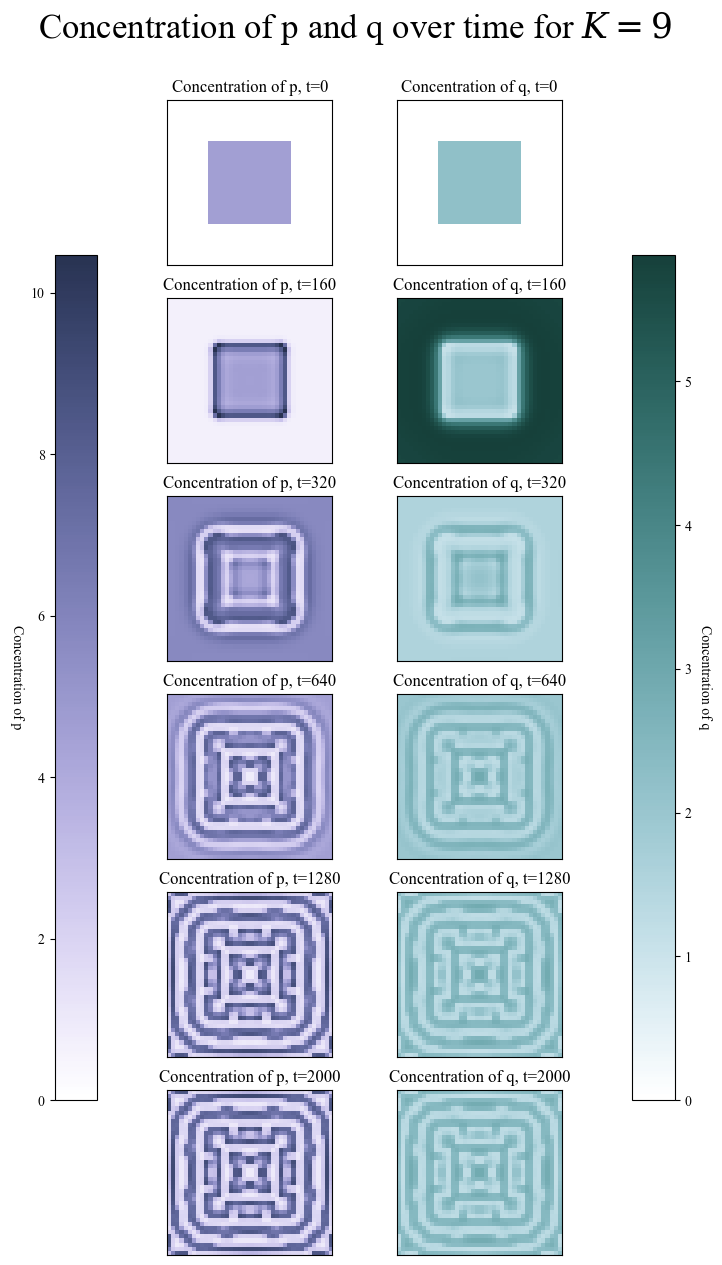

In [5]:
color_grad_p = sns.cubehelix_palette(start=2.8, rot=.1, light=1, dark=0.2, as_cmap=True)
color_grad_q = sns.cubehelix_palette(start=2.3, rot=.1, light=1, dark=0.2, as_cmap=True)
alpha_param = 1

p_max = np.max([np.max(p) for p in p_save])
q_max = np.max([np.max(q) for q in q_save])
p_min = np.min([np.min(p) for p in p_save])
q_min = np.min([np.min(q) for q in q_save])

fig, ax = plt.subplots(len(p_save),2, figsize=(8,15), dpi=100)

cbar_p = fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=color_grad_p, 
        norm=plt.Normalize(vmin=p_min, vmax=p_max)
    ),
    ax=ax[:, 0],
    orientation='vertical',
    pad=0.25,
    location='left'
)
cbar_p.set_label('Concentration of p', rotation=270, labelpad=15)
cbar_p.ax.yaxis.set_label_position('left')
cbar_p.ax.yaxis.tick_left()

cbar_q = fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=color_grad_q, 
        norm=plt.Normalize(vmin=q_min, vmax=q_max)
        ), 
    ax=ax[:,1], 
    orientation='vertical',
    pad=0.25,
    location='right'
    )
cbar_q.set_label('Concentration of q', rotation=270, labelpad=15)

for axi in ax.flatten():
    #axi.axis('off')
    axi.set_xticks([])
    axi.set_yticks([])
    axi.set_aspect('equal')

for i in range(len(p_save)):
    ax[i,0].imshow(p_save[i], cmap=color_grad_p, alpha=alpha_param, vmin=p_min, vmax=p_max)
    ax[i,0].set_title('Concentration of p, t={}'.format(int(saves[i])))
    ax[i,1].imshow(q_save[i], cmap=color_grad_q, alpha=alpha_param, vmin=q_min, vmax=q_max)
    ax[i,1].set_title('Concentration of q, t={}'.format(int(saves[i])))


fig.suptitle('Concentration of p and q over time for $K={}$'.format(K), fontsize=25, y=0.94);

#fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=150)
#for axi in ax.flatten():
#    axi.axis('off')
#    axi.set_aspect('equal')
#
#ax[0].imshow(p_final, cmap=color_grad_p, interpolation='nearest', alpha=alpha_param)
#colorbar = fig.colorbar(ax[0].imshow(p_final, cmap=color_grad_p, interpolation='nearest', alpha=alpha_param), ax=ax[0])
#colorbar.set_label('Concentration of p', rotation=270, labelpad=15)
#
#ax[1].imshow(q_final, cmap=color_grad_q, interpolation='nearest', alpha=alpha_param)
#colorbar = fig.colorbar(ax[1].imshow(q_final, cmap=color_grad_q, interpolation='nearest', alpha=alpha_param), ax=ax[1])
#colorbar.set_label('Concentration of q', rotation=270, labelpad=15)

plt.savefig('concentration_over_time_K{}.png'.format(K), bbox_inches='tight', dpi=200)

In [6]:
L = 40

D_p = 1
D_q = 8
C = 4.5
K = np.arange(7,13,1)
dt = 0.01
saves = [0]


p_finals = []
q_finals = []

min_q = 0
max_q = 0
min_p = 0
max_p = 0


for k in K:
    print("Running for K =", k)
    p_init = construct_M(L, boundary=True, param=(C), term=0.1)
    q_init = construct_M(L, boundary=True, param=(k/C), term=0.2)

    params = [D_p, D_q, C, k]
    p_final, q_final, p_save, q_save = run_euler(params, p_init, q_init, dt, tmax=2000, saves=saves)
    p_finals.append(p_final)
    q_finals.append(q_final)

    p_max = np.max(p_final)
    p_min = np.min(p_final)
    q_max = np.max(q_final)
    q_min = np.min(q_final)

    if p_min < min_p:
        min_p = p_min
    if p_max > max_p:
        max_p = p_max
    if q_min < min_q:
        min_q = q_min
    if q_max > max_q:
        max_q = q_max


Running for K = 7
Running for K = 8
Running for K = 9
Running for K = 10
Running for K = 11
Running for K = 12


I next ran the simulations again but this time for varying $K \in [7, 8, 9, 10, 11, 12]$. The plot below shows the result of all simulations for both concentrations $q$ and $p$, but only shows the final time step of the simulation. All plots are again symmetric, but express different patterns according to their respective value $K$. 

Like before, it is noticable, that the concentration of $p$ generally has a much larger scale than $q$.

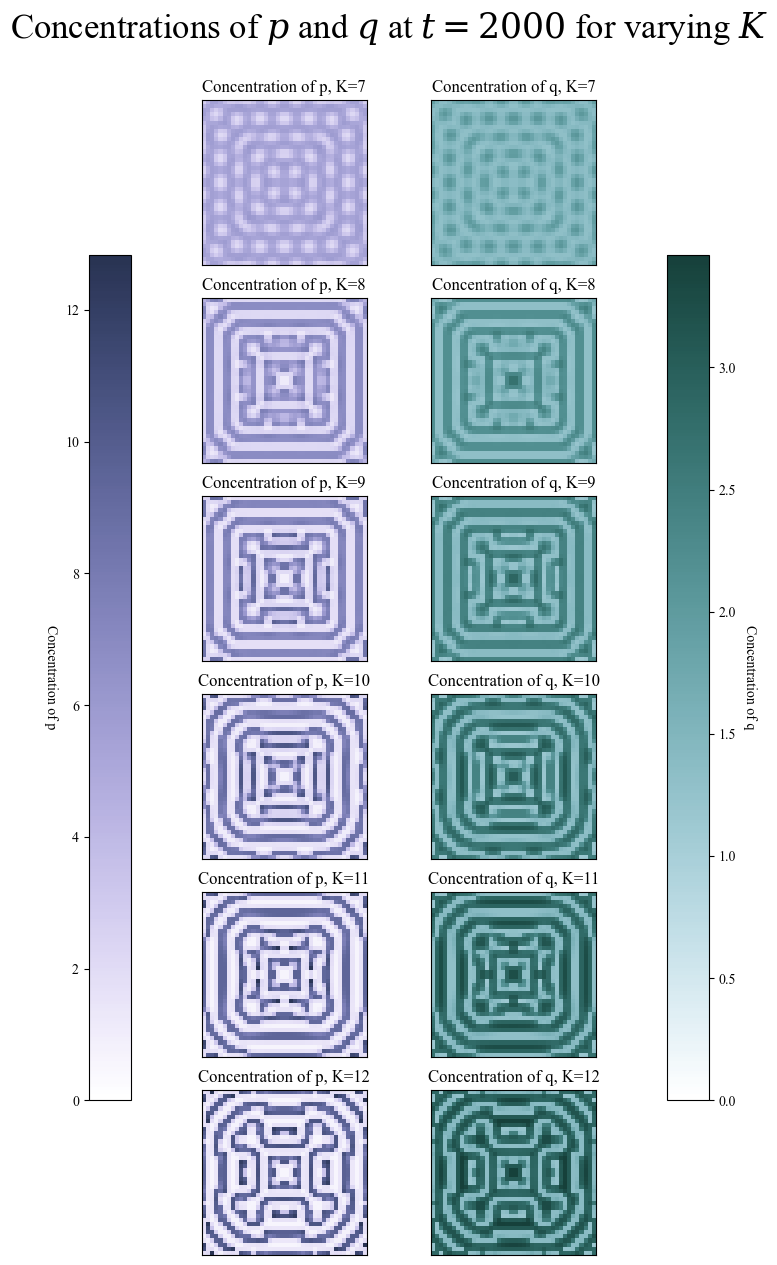

In [7]:
alpha_param=1

fig, ax = plt.subplots(len(K),2, figsize=(8,15), dpi=100)

# Add one big colorbar for all plots
cbar_q = fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=color_grad_p, 
        norm=plt.Normalize(vmin=min_p, vmax=max_p)
        ), 
    ax=ax[:,0], 
    orientation='vertical', 
    pad=0.25,
    location='left'
    )
cbar_q.ax.yaxis.set_label_position('left')
cbar_q.ax.yaxis.tick_left()
cbar_q.set_label('Concentration of p', rotation=270, labelpad=15)

cbar_p = fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=color_grad_q, 
        norm=plt.Normalize(vmin=min_q, vmax=max_q)
    ), 
    ax=ax[:,1], 
    orientation='vertical', 
    pad=0.25,
    location='right'
    )
cbar_p.set_label('Concentration of q', rotation=270, labelpad=15)

for axi in ax.flatten():
    #axi.axis('off')
    axi.set_xticks([])
    axi.set_yticks([])
    axi.set_aspect('equal')

for i in range(len(K)):
    ax[i,0].imshow(p_finals[i], cmap=color_grad_p, alpha=alpha_param, vmin=min_p, vmax=max_p)
    ax[i,0].set_title('Concentration of p, K={}'.format(K[i]))
    ax[i,1].imshow(q_finals[i], cmap=color_grad_q, alpha=alpha_param, vmin=min_q, vmax=max_q)
    ax[i,1].set_title('Concentration of q, K={}'.format(K[i]))

fig.suptitle('Concentrations of $p$ and $q$ at $t=2000$ for varying $K$', fontsize=25, y=0.94);
plt.savefig('concentration_varying_K.png', bbox_inches='tight', dpi=200)